#### Problem Statement

Develop a minimum viable solution for the prediction of the rating for the given data set.

In [45]:
#immporting the required pakages

import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from collections import Counter


ImportError: cannot import name 'delayed' from 'sklearn.utils.fixes' (C:\Users\bvnmu\anaconda3\lib\site-packages\sklearn\utils\fixes.py)

In [2]:
#reading the data set for our analysis

df = pd.read_json('Musical_Instruments_5.json',lines = True)

In [3]:
#printing first few rows of the data set to get familiar with the data set

df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


##### Understanding the data set

This data set consist of 9 columns   
Description of columns in the file:

1. reviewerID - ID of the reviewer
2. asin - ID of the product
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review

In [4]:
#shape of the data set

df.shape

(10261, 9)

In [5]:
#checking the type of each columns

df.dtypes

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object

In [6]:
#checking the null values in the data set

df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Their are no null values in the data set except in reviewerName column which is not even required for predicting the ratings.

In [7]:
#droping unwanted columns from our data set

cols = ['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime']

df.drop(columns = cols,inplace = True,axis = 1)

In [8]:
df.head(3)

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5,good
1,The product does exactly as it should and is q...,5,Jake
2,The primary job of this device is to block the...,5,It Does The Job Well


In [9]:
#checking for duplicate values in the data set

print('Total number of duplicate values in the data set is/are: ',df.duplicated().sum())

Total number of duplicate values in the data set is/are:  0


##### Pre Processing steps

Steps to be followed before we apply our algorithms for predicting the ratings from the data set.

In [10]:
#concatinating the reviewText and summary text into one column

df['text'] = df['reviewText'] + ' ' + df['summary']

In [11]:
df.head(3)

,reviewText,overall,summary,text
0,"Not much to write about here, but it does exac...",5,good,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...,5,Jake,The product does exactly as it should and is q...
2,The primary job of this device is to block the...,5,It Does The Job Well,The primary job of this device is to block the...


In [12]:
#dropping the unnecessary columns from our data set

df.drop(columns = ['reviewText','summary'],inplace = True,axis = 1)

In [13]:
df.head(3)

,overall,text
0,5,"Not much to write about here, but it does exac..."
1,5,The product does exactly as it should and is q...
2,5,The primary job of this device is to block the...


<AxesSubplot:>

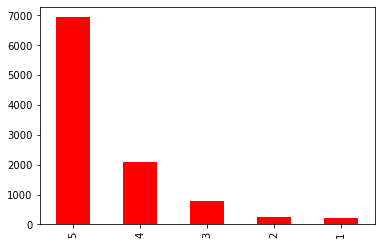

In [14]:
# checking for the balance in the data set with respect o rating

df.overall.value_counts().plot(kind='bar',color='red')

we can see that close to 70% of data set skewed towards rating 5 and very less data set is having 1,2,3,4 ratings which will make it difficult for our model to predict the correct ratings. we have to perform some pre processing steps to make it balance.

we will first combine 1,2 and 3 (poor) ratings together and mark it as 0 and 4 and 5 (good) as 1, then if required we will perform over/under sampling to balance our data set.

In [15]:
#combining the ratings together

def mergerating(rating):
    # Replacing ratings of 1,2,3 with 0 (poor) and 4,5 with 1 (good)
    if(int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0
    else: 
        return 1
df.overall = df.overall.apply(mergerating) 

<AxesSubplot:>

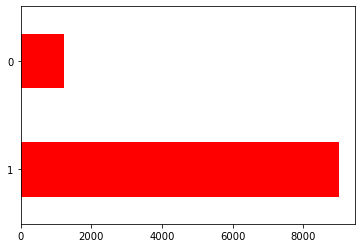

In [16]:
#after merging

df.overall.value_counts().plot(kind='barh',color='red')

we have to perform over/under sampling with the data set to make it balanced but before we will complete our pre processing steps first and then will do balancing of data set.

In [17]:
#function to convert text into lower case

def lower_case(text):
    return text.lower()


In [18]:
#Remove non ASCII values from the text if any for this we will use ord() to find ASCII value of the character
#Assumption: we will only use range of ASCII value from 0-128
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)

In [19]:
# Fix Abbreviations

def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
#     data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
#     data_str = re.sub(r'\bno+\b', 'no', data_str)
#     data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
#     data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str

In [20]:
##Remove punctuations mentions and alphanumeric characters

def remove_features(data_str):
# compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
#     punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
# convert to lowercase
    data_str = data_str.lower()
# remove hyperlinks
    data_str = url_re.sub(' ', data_str)
# remove @mentions
    data_str = mention_re.sub(' ', data_str)
# remove puncuation
#     data_str = punc_re.sub(' ', str(data_str))
# remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
# remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word):
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word):
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
# remove unwanted space, *.split() will automatically split on
# whitespace and discard duplicates, the " ".join() joins the
# resulting list into one string.
    return " ".join(cleaned_str.split())

In [31]:
##Remove stop words
def remove_stops(data_str):
# expects a string
    stopWords = set(stopwords.words("english"))
    punc = list(punctuation)
    stopWords.update(punc)
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stopWords:
# rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

The POS tagger in the NLTK library outputs specific tags for certain words. The list of POS tags is as follows, with examples of what each POS stands for.

CC coordinating conjunction    
CD cardinal digit     
DT determiner     
EX existential there (like: “there is” … think of it like “there exists”)    
FW foreign word    
IN preposition/subordinating conjunction    
JJ adjective ‘big’   
JJR adjective, comparative ‘bigger’    
JJS adjective, superlative ‘biggest’     
LS list marker 1)    
MD modal could, will     
NN noun, singular ‘desk’    
NNS noun plural ‘desks’       
NNP proper noun, singular ‘Harrison’     
NNPS proper noun, plural ‘Americans’     
VB verb, base form take     
VBD verb, past tense took      
VBG verb, gerund/present participle taking     
VBN verb, past participle taken     
VBP verb, sing. present, non-3d take    
VBZ verb, 3rd person sing. present takes      
PDT predeterminer ‘all the kids’    
  

POS possessive ending parent’s              
PRP personal pronoun I, he, she               
PRP$ possessive pronoun my, his, hers                  
RB adverb very, silently,                        
RBR adverb, comparative better                         
RBS adverb, superlative best                         
RP particle give up                               
TO, to go ‘to’ the store                             
UH interjection, errrrrrrrm                               
WDT wh-determiner which                                   
WP wh-pronoun who, what                                     
WP$ possessive wh-pronoun whose                                       
WRB wh-abverb where, when                                             

out of all the tags we are only intrested in verbs, adjectives and nouns, so we will be using only
###### JJ adjective ‘big’   
###### JJR adjective, comparative ‘bigger’    
###### JJS adjective, superlative ‘biggest’     
###### NN noun, singular ‘desk’    
###### NNS noun plural ‘desks’       
###### NNP proper noun, singular ‘Harrison’     
###### NNPS proper noun, plural ‘Americans’     
###### VB verb, base form take     
###### VBD verb, past tense took      
###### VBG verb, gerund/present participle taking     
###### VBN verb, past participle taken     
###### VBP verb, sing. present, non-3d take    
###### VBZ verb, 3rd person sing. present takes 

In [22]:
# Part-of-Speech Tagging
def tag_and_remove(data_str):
    cleaned_str = ' '
# noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
# adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
# verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
# adverb
    ad_tags = ['RB','RBR','RBS','RP']
    nltk_tags = nn_tags + jj_tags + vb_tags + ad_tags
# break string into 'words'
    text = data_str.split()
# tag the text and keep only those with the right tags
    tagged_text = pos_tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '
    return cleaned_str

In [23]:
##Lemmatization
def lemmatize(data_str):
# expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str

In [24]:
#converting the text into lower case

# functions = ['lower_case','strip_non_ascii','fix_abbreviation','remove_features','remove_stops','tag_and_remove','lemmatize']

df.text = df.text.apply(lower_case)

In [25]:
#removing the non ASCII characters from the text

df.text = df.text.apply(strip_non_ascii)

In [26]:
#removing the abbreviations from the text
df.text = df.text.apply(fix_abbreviation)


In [27]:
#removing unwanted characters from the text such as numbers or alpha numeric characters and hyperlinks

df.text = df.text.apply(remove_features)

In [32]:
#removing stopwords from the text
# nltk.download()
df.text = df.text.apply(remove_stops)

In [33]:
#adding tags with the words

df.text = df.text.apply(tag_and_remove)

In [40]:
pd.options.display.max_colwidth = 1000
df.head(3)

,overall,text
0,1,much write exactly supposed to. filters pop sounds. recordings much crisp. lowest prices pop filters amazon well buy honestly work good
1,1,product exactly quite affordable.i realized double screened even better expected.as added screens carries small hint smell old grape candy used cannot stop putting pop filter next nose smelling recording. needed pop work well expensive even come pleasing mine jake
2,1,primary job device block breath otherwise produce popping allowing voice pass noticeable reduction volume high frequencies. double cloth filter blocks pops lets voice coloration. metal clamp mount attaches mike stand secure enough keep attached. goose neck needs little coaxing stay put it. job well


In [41]:
df.text = df.text.apply(lemmatize)

In [42]:
df.head(3)

,overall,text
0,1,much write exactly suppose to. filter pop sounds. recording much crisp. lowest price pop filter amazon well buy honestly work good
1,1,product exactly quite affordable.i realize double screen even better expected.as add screen carry small hint smell old grape candy use cannot stop put pop filter next nose smell recording. need pop work well expensive even come please mine jake
2,1,primary job device block breath otherwise produce pop allow voice pas noticeable reduction volume high frequencies. double cloth filter block pop let voice coloration. metal clamp mount attache mike stand secure enough keep attached. goose neck need little coax stay put it. job well
